# Query Sequence Analysis (Deep Learning Feed Forward Network)

This notebook focuses on sequence analysis, when presented with a workload schedule / sequence of queries. In an average day to day work activity, particular query patterns can be discerned. This pattern distinction allows us to discern which queries will be susceptible to execution over time, allowing us to know ahead of time which queries will be executed against the database.

## Data Preprocessing

### Module Installation and Importing Libraries

* https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
* https://vertexai-plaidml.readthedocs-hosted.com/en/latest/installing.html

In [1]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import IsolationForest
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# plaidml keras
import plaidml.keras
plaidml.keras.install_backend()
# keras
import keras as ke
print('keras: %s' % ke.__version__)
import math

scipy: 1.1.0
numpy: 1.15.4
pandas: 0.23.4
sklearn: 0.20.2
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [2]:
# Experiment Config
tpcds='TPCDS1' # Schema upon which to operate test
lag=13 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')

nrows=None
test_split=.5 # Denotes which Data Split to operate under when it comes to training / validation

# Top Consumer Identification
y_label = ['COST','CARDINALITY','BYTES','IO_COST','TEMP_SPACE','TIME']
black_list = ['TIMESTAMP','SQL_ID'] # Columns which will be ignored during type conversion, and later used for aggregation
contamination = .1
parallel_degree = -1

# Net Config
epochs=150
batch_size=32
activation='sigmoid'
dropout=.4
layers=2
initializer='zero'

### Read data from file into Pandas Dataframes

In [3]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_vsql_plan_path = root_dir + '/rep_vsql_plan.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, nrows=nrows)
rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path, nrows=4000000)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_vsql_plan_df.columns = prettify_header(rep_vsql_plan_df.columns.values)

print(rep_hist_snapshot_df.columns.values)
print('------------------------------------------')
print(rep_vsql_plan_df.columns)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (6,19,20,21,22,25,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Dealing with empty values

Subsituating N/A values with 0.

In [4]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_VSQL_PLAN Features ' + str(len(rep_vsql_plan_df.columns)) + ': ' + str(get_na_columns(df=rep_vsql_plan_df,headers=rep_vsql_plan_df.columns)) + "\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    df = df.replace('', 0)
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_vsql_plan_df = fill_na(df=rep_vsql_plan_df)

N/A Columns


 REP_HIST_SNAPSHOT Features 90: ['OPTIMIZER_COST', 'OPTIMIZER_MODE', 'OPTIMIZER_ENV_HASH_VALUE', 'LOADED_VERSIONS', 'MODULE', 'ACTION', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_SCHEMA_NAME', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'ELAPSED_TIME_TOTAL', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLSEXEC_TIME_DELTA', 'JAVEXEC_TIME_TOTAL', 'JAVEXEC_TIME_DELTA', 'IO_OFFLOAD_ELIG_BYTES_TOTAL', 

### Type conversion

Each column is converted into a column of type values which are Integer64.

In [5]:
def handle_numeric_overflows(x):
    """
    Accepts a dataframe column, and 
    """
    try:
        #df = df.astype('int64')
        x1 = pd.DataFrame([x],dtype='int64')
    except ValueError:
        x = 9223372036854775807 # Max int size
    return x

for col in rep_vsql_plan_df.columns:
    try:
        rep_vsql_plan_df[col] = rep_vsql_plan_df[col].astype('int64')
    except OverflowError:
        
        # Handles numeric overflow conversions by replacing such values with max value inside the dataset.
        rep_vsql_plan_df[col] = rep_vsql_plan_df[col].apply(handle_numeric_overflows)
        rep_vsql_plan_df[col] = rep_vsql_plan_df[col].astype('int64')
    except Exception as e:
        if col not in black_list:
            rep_vsql_plan_df.drop(columns=col, inplace=True)
            print('Dropped column [' + col + ']')
            
print(rep_hist_snapshot_df.columns)
print(rep_vsql_plan_df.columns)

Dropped column [OPERATION]
Dropped column [OPTIONS]
Dropped column [OBJECT_NODE]
Dropped column [OBJECT_OWNER]
Dropped column [OBJECT_NAME]
Dropped column [OBJECT_ALIAS]
Dropped column [OBJECT_TYPE]
Dropped column [OPTIMIZER]
Dropped column [OTHER_TAG]
Dropped column [PARTITION_START]
Dropped column [PARTITION_STOP]
Dropped column [DISTRIBUTION]
Dropped column [QBLOCK_NAME]
Dropped column [OTHER_XML]
Index(['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'SQL_ID', 'PLAN_HASH_VALUE',
       'OPTIMIZER_COST', 'OPTIMIZER_MODE', 'OPTIMIZER_ENV_HASH_VALUE',
       'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'MODULE', 'ACTION',
       'SQL_PROFILE', 'FORCE_MATCHING_SIGNATURE', 'PARSING_SCHEMA_ID',
       'PARSING_SCHEMA_NAME', 'PARSING_USER_ID', 'FETCHES_TOTAL',
       'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA',
       'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA',
       'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL',
    

### Changing Matrix Shapes

Changes dataframe shape, in an attempt to drop all numeric data. Below's aggregated data is done so on:
* SNAP_ID
* INSTANCE_NUMBER
* DBID
* SQL_ID

In [6]:
print("Shape Before Aggregation: " + str(rep_hist_snapshot_df.shape))
#
# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT) and drop all numeric
df = rep_hist_snapshot_df.groupby(['SNAP_ID'])['SQL_ID'].apply(list).reset_index()
#
print("Shape After Aggregation: " + str(df.shape))
print(type(df))
print(df.head(100))

print('---------------------------')

# Further Aggregation on V$SQL table
print('Header Lengths [Before Pivot]')
print('REP_VSQL_PLAN: ' + str(len(rep_vsql_plan_df.columns)))
# Group By Values by PLAN_HASH_VALUE,TIMESTAMP, sum all metrics (for table REP_VSQL_PLAN
rep_vsql_plan_df = rep_vsql_plan_df.groupby(['SQL_ID']).sum()
rep_vsql_plan_df.reset_index(inplace=True)
print('\nHeader Lengths [After Pivot]')
print('REP_VSQL_PLAN: ' + str(len(rep_vsql_plan_df.columns)) + "\n")
#rep_vsql_plan_df.drop(columns=black_list, inplace=True) # This is required since it will impede future aggragate functions to be carried out.
print(rep_vsql_plan_df.columns)

Shape Before Aggregation: (1589392, 90)
Shape After Aggregation: (19831, 2)
<class 'pandas.core.frame.DataFrame'>
    SNAP_ID                                             SQL_ID
0     43414  [03ggjrmy0wa1w, 06dymzb481vnd, 0aq14dznn91rg, ...
1     43415  [0w26sk6t6gq98, 0y080mnfaqk3u, 0y080mnfaqk3u, ...
2     43416  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
3     43417  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
4     43418  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
5     43419  [0kcbwucxmazcp, 0kkhhb2w93cx0, 0w26sk6t6gq98, ...
6     43420  [0a4un42k35fzy, 0a7q9v9nd2qc1, 0hhmdwwgxbw0r, ...
7     43421  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
8     43422  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
9     43423  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
10    43424  [0kcbwucxmazcp, 0kkhhb2w93cx0, 1hxfbnas8xr2j, ...
11    43425  [09vrdx888wvvb, 0a7q9v9nd2qc1, 0hhmdwwgxbw0r, ...
12    43426  [03ggjrmy0wa1w, 06dymzb481vnd, 0aq14dznn91rg, ...
13  

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [7]:
df.sort_index(ascending=True,inplace=True)
print(df.shape)
print(df.head(100))

(19831, 2)
    SNAP_ID                                             SQL_ID
0     43414  [03ggjrmy0wa1w, 06dymzb481vnd, 0aq14dznn91rg, ...
1     43415  [0w26sk6t6gq98, 0y080mnfaqk3u, 0y080mnfaqk3u, ...
2     43416  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
3     43417  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
4     43418  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
5     43419  [0kcbwucxmazcp, 0kkhhb2w93cx0, 0w26sk6t6gq98, ...
6     43420  [0a4un42k35fzy, 0a7q9v9nd2qc1, 0hhmdwwgxbw0r, ...
7     43421  [01tp87bk1t2zv, 06dymzb481vnd, 0jj0ct4x4gy27, ...
8     43422  [01tp87bk1t2zv, 06dymzb481vnd, 0a08ug2qc1j82, ...
9     43423  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
10    43424  [0kcbwucxmazcp, 0kkhhb2w93cx0, 1hxfbnas8xr2j, ...
11    43425  [09vrdx888wvvb, 0a7q9v9nd2qc1, 0hhmdwwgxbw0r, ...
12    43426  [03ggjrmy0wa1w, 06dymzb481vnd, 0aq14dznn91rg, ...
13    43427  [01tp87bk1t2zv, 0w26sk6t6gq98, 130r442w3nfny, ...
14    43428  [01tp87bk1t2zv, 06dymzb481vnd, 

### Univariate Selection

This sextion treats the dataset as a univariate dataset. Therefore the SNAP_ID pertaining to each set of SQL_IDs is removed, with the intent of future classifiers training solely on past SQL executions

In [8]:
print(df.shape)
del df['SNAP_ID']
print(df.shape)

(19831, 2)
(19831, 1)


### Top SQL Identification

This section carries out a pruning operation in an attempt to isolate the most expensive of queries within the generated trace.Only the highest expensive queries are retained for the future of the experiment, since it is considered too costly an attempt to try and predict ALL incoming SQL activity.

More work concerning Top Consumer Isolation can be found within the following notebook: 'Schedule TPC-DS Top Consumer Profiling'.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.1,
        max_features=1.0, max_samples=256, n_estimators=100, n_jobs=-1,
        random_state=0, verbose=0)


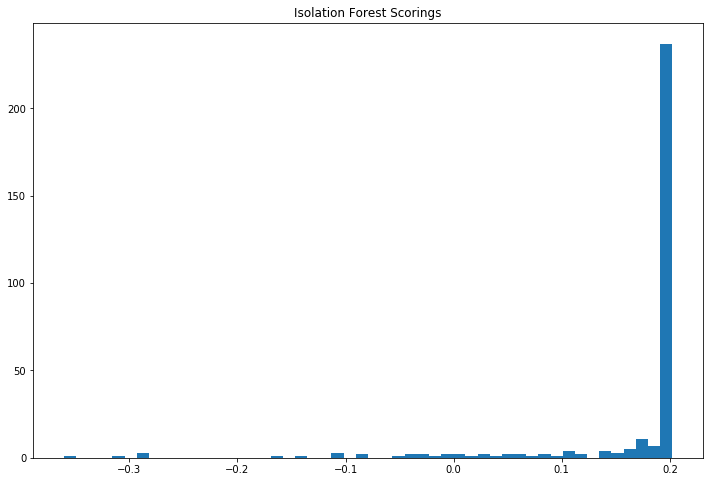

In [9]:
class IsolationForestWrapper:
    """
    This class wraps up logic to the Isolation Forest Outlier Detection functionality.
    """
    
    def __init__(self, X, contamination=.1, parallel_degree=1):
        """
        Constructor Method
        
        :param X - Pandas Dataframe
        :param contamination - Real value
        :param parallel_degree - Parellization parameter
        
        :return: None
        """
        self.X = X.values
        self.model = IsolationForest(n_estimators=100, max_samples=256, contamination=contamination, random_state=0, n_jobs=parallel_degree)
        self.model.fit(self.X)
        self.scorings = []
        print(self.model)
        
    def __get_threshold_vector(self):
        """
        Calculates a vector threshold, above which will be used to identify outliers. This method is used for evaluating the 
        trained machine-learning model.
        
        :return: Numpy vector which represents a threshold vector
        """
        mean = np.mean(self.X)
        std = np.std(self.X)
        std3 = np.multiply(std, 3)
        return np.add(mean, std3)
    
    def __calculate_expected_labels(self):
        """
        Estimates label clustering by comparing them to a threshold mean value. These labels will be used to gauge a scoring 
        for the unsupervised clustering achieved by the IForest algorithm.
        
        :return: A list of the expected output labels.
        """
        mean_vect = self.__get_threshold_vector()
        mean_labels = []
        for vector in self.X:
            if np.greater(vector, mean_vect).any():
                mean_labels.append(-1)
            else:
                mean_labels.append(1)
        return mean_labels
    
    def retrieve_scorings(self):
        """
        This method retrieves the per vector IForest scorings, after the model has been trained.
        
        :return: List of Iforest scorings
        """
        return self.model.decision_function(self.X)
    
    def plot_scorings(self):
        """
        Distributes into 50 bin histogram.
        
        :return: None
        """
        scores = self.retrieve_scorings()
        plt.figure(figsize=(12, 8))
        plt.hist(scores, bins=50);
        plt.title('Isolation Forest Scorings')
        plt.show()
    
    def predict_labels(self):
        """
        Caries out predicton on feature matrix 'X'
        
        :return: List of predicted output labels.
        """
        return self.model.predict(self.X) 
    
    def predict_labels(self, X):
        """
        Caries out predicton on feature matrix 'X'
        
        :return: List of predicted output labels.
        """
        return self.model.predict(X)
    
    def outlier_score_accuracy(self):
        """
        Returns a score which evaluates the accuracy with the number of isolated outliers. The closer to 0 the score, the more accurate the evaluation
        
        :return: Positive Integer (Squared and Square Rooted) denoting the delta scoring between predicted and actual
        """
        if self.scorings is None or len(self.scorings) == 0:
            raise ValueError('Scorings list is empty!')
        elif len(self.scorings) > 2:
            raise ValueError('Scorings list length is greater than 2! Must be composed of the following structure [scoring1, scoring2]')
        
        return math.sqrt((self.scorings[1] - self.scorings[0])**2)
    
    def evaluate_labels(self):
        """
        This function calculates the expected inlier and outlier vectors based on a statistical threshold, and then matches
        these expectations to the IForest predictions. Results are plotted, and gauge by scored ROC score, and lowest error delta
        
        :return: None
        """
        y = self.__calculate_expected_labels()
        yhat = self.predict_labels()
        
        unique, counts = np.unique(y, return_counts=True)
        print('Expected Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == -1:
                self.scorings.append(counts[i])
        unique, counts = np.unique(yhat, return_counts=True)
        print('Isolated Label Distribution')
        for i in range(len(unique)):
            print('Label [' + str(unique[i]) + '] -> Count [' + str(counts[i]) + ']')
            if unique[i] == -1:
                self.scorings.append(counts[i])
        
        print("\n----\nAccuracy: " + str(accuracy_score(y, yhat)))
        print("F-Score: " + str(f1_score(y, yhat, average='binary')))
        print('---')
        print("Outlier Score Precision [" + str(self.outlier_score_accuracy()) + "]")
        
        fpr_RF, tpr_RF, thresholds_RF = roc_curve(y, yhat)
        print(fpr_RF)
        print(tpr_RF)
        auc_RF = roc_auc_score(y, yhat)
        print('AUC RF:%.3f'% auc_RF)
        plt.plot(fpr_RF, tpr_RF,'r-',label = 'RF AUC: %.3f'%auc_RF)
        plt.plot([0,1],[0,1],'k-',label='random')
        plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
        plt.legend()
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
ifw = IsolationForestWrapper(X=rep_vsql_plan_df[y_label], contamination=contamination, parallel_degree=parallel_degree)
ifw.plot_scorings()

### Stripping Inlier SQL_ID's

All inliers SQL_IDs are stripped away, whilst those predicted as outliers are retained for the continuation of this experiment.

In [10]:
sql_ids = np.unique(rep_vsql_plan_df['SQL_ID'].values)
sql_map = {}
for sql in sql_ids:
    df_plan = rep_vsql_plan_df.loc[rep_vsql_plan_df['SQL_ID'] == sql]
    plan_costings = df_plan[y_label]
    sql_map[sql] = ifw.predict_labels(plan_costings.values)[0]
print(sql_map)

outlier_ids = []
for key, value in sql_map.items():
    if value == -1:  # -1 Denotes Outliers, as predicted by the isolation forst
        outlier_ids.append(key)
print('Outlier SQL_IDs: \n' + str(outlier_ids))

for index, row_sql_ids in df.iterrows():
    snap_list = []
    for sql_id in row_sql_ids['SQL_ID']:
        if sql_id in outlier_ids:
            snap_list.append(sql_id)
    df['SQL_ID'].iloc[index] = snap_list
print(df)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and w

{'01tp87bk1t2zv': -1, '03ggjrmy0wa1w': 1, '06dymzb481vnd': -1, '09vrdx888wvvb': 1, '0a08ug2qc1j82': 1, '0aadu2kp270dv': 1, '0aq14dznn91rg': 1, '0axwf3djk6qhw': 1, '0f60bzgt9127c': 1, '0ga8vk4nftz45': 1, '0gyb2wqdu4d9k': 1, '0hdquu87pydzk': 1, '0jj0ct4x4gy27': 1, '0jsk8n9usaxzb': 1, '0kgv07zrthbk9': 1, '0rdgvhw9f16d3': 1, '0vtkrfgrcwxh6': 1, '0y080mnfaqk3u': -1, '0ym9wzzys5zax': 1, '10pyxwav0mqs9': 1, '130r442w3nfny': 1, '13a9r2xkx1bxb': 1, '1480t2vk3001h': 1, '14f5ngrj3cc5h': 1, '18kgfax58817q': 1, '193ncz0tf25hw': 1, '1a3dr7y41qvk8': 1, '1aajwypydy0wu': 1, '1fn8v91f0arf0': -1, '1jhyrdp21f2q6': 1, '1ms8wj24sqny4': 1, '1pgnzc6zf7ctc': 1, '1pv23p59mjs0v': 1, '1r7b985mxqj71': 1, '1u93uh94534r9': 1, '1u97hwfu7dcmz': 1, '1v2b661suttyp': 1, '1wj0cn946b2d0': 1, '1wk0t84cwr5ps': 1, '1wpns6pagm2qj': 1, '2046z7kdh823h': -1, '20bqsr6btd9x9': 1, '22xrvu87xq80w': 1, '248suhpf1dbya': 1, '24u3pyk3mymm4': 1, '24x3yjn39ycjs': 1, '26jdypa362wv9': 1, '27ws0jh2nqdwj': 1, '288tccrcj5fyj': 1, '297gc42f2hwdd

### Label Encoding

Since this experiment deals with prediction of upcoming SQL_IDs, respectice SQL_ID strings need to labelled as a numeric representation. Label Encoder will be used here to convert SQL_ID's into a numeric format, which are in turn used for training. Evaluation (achieved predictions) is done so also in numeric format, at which point the label encoder is eventually used to decode back the labels into the original, respetive SQL_ID representation.

This section of the experiment additionally converts the targetted label into a binarized version of the previous achieved categorical numeric values.

* https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

In [11]:
class LabelEncoder:
    """
    Scikit Label Encoder was acting up with the following error whilst using the transform function, even though I tripled 
    checked that the passed data was exactly the same as the one used for training:
    
    * https://stackoverflow.com/questions/46288517/getting-valueerror-y-contains-new-labels-when-using-scikit-learns-labelencoder
    
    So I have rebuilt a similar functionality to categorize my data into numeric digits, as the LabelEncoder is supposed to do.
    """
    
    def __init__(self):
        self.__class_map = {}
        self.__integer_counter = 0
    
    def fit(self, X):
        """
        :param - X: python list
        """
        for val in X:
            if val not in self.__class_map:
                self.__class_map[val] = self.__integer_counter
                self.__integer_counter += 1
    
    def transform(self, X):
        """
        param - X: python list
        """
        encoded_map = []
        for val in X:
            if val in self.__class_map:
                value = self.__class_map[val]
                encoded_map.append(value)
            else:
                raise ValueError('Label Mismatch - Encountered a label which was not trained on.')
        return encoded_map
    
    def get_class_map(self):
        """
        Returns original classes as a list
        """
        class_map = []
        for key, value in self.__class_map.items():
            class_map.append(key)
        return class_map
    
    def get_encoded_map(self):
        """
        Returns class encodings as a list
        """
        encoded_map = []
        for key, value in self.__class_map.items():
            encoded_map.append(value)
        return encoded_map

In [12]:
print(df.shape)
print(df.head(10))
le = LabelEncoder()
for index, row in df.iterrows():
    sql_id_list = row['SQL_ID']
    le.fit(sql_id_list)
for index, row in df.iterrows():
    sql_id_list = row['SQL_ID']
    transformed_list = le.transform(sql_id_list)
    df['SQL_ID'].iloc[index] = transformed_list 

print("\n----------------------------------\n\nAvailable Classes:")
print('Total SQL_ID Classes: ' + str(len(le.get_class_map())))
print(le.get_class_map()[:10])
print(df.shape)
print(df.head(10))

(19831, 1)
                                              SQL_ID
0  [06dymzb481vnd, 6u001adh62r0f, 6u001adh62r0f, ...
1  [0y080mnfaqk3u, 0y080mnfaqk3u, 0y080mnfaqk3u, ...
2  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
3  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
4  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
5                                                 []
6                                                 []
7  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
8  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...
9  [01tp87bk1t2zv, 06dymzb481vnd, 0y080mnfaqk3u, ...

----------------------------------

Available Classes:
Total SQL_ID Classes: 31
['06dymzb481vnd', '6u001adh62r0f', '87gtj5jaq4a3t', 'd6vqfmt62hypx', 'd7w1dugmzb9n9', 'fc0va0vju750z', 'gh5w0gcyfaujs', '0y080mnfaqk3u', '1fn8v91f0arf0', '2046z7kdh823h']
(19831, 1)
                                              SQL_ID
0  [0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, ...
1  [7, 7, 7, 8, 9, 10, 10, 11, 11, 12

### Data Normalization

A note regarding normalization. Normalization for this experiment was purposely skipped, since training & testing data will be one-hot encoded.

### Feature Padding

Since there isn't a fixed number of SQL_ID's per SNAP_ID, each set of SQL_IDs need to be padded so as to assume an equal number if SQL_IDs for the purpose of model fitting.

In [13]:
print("Length at index 0: " + str(len(df['SQL_ID'].iloc[0])))
print(df['SQL_ID'].iloc[0])
print("Length at index 1: " + str(len(df['SQL_ID'].iloc[1])))
print(df['SQL_ID'].iloc[1])
print("Length at index 2: " + str(len(df['SQL_ID'].iloc[2])))
print(df['SQL_ID'].iloc[2])

# Retrieve largest length
def pad_datamatrix(df):
    """
    Iterates over dataframe and pads SQL_ID lists accordingly with -1 values, denoting empty SQL_ID slots.
    """
    row_sizes = []
    for index, row in df.iterrows():
        row_sizes.append(len(row['SQL_ID']))
    max_row_size = max(row_sizes)
    
    # Pad Dataframe Values
    i = 0
    for index, row in df.iterrows():
        length = len(row['SQL_ID'])
        diff = max_row_size - length
        if diff != 0:
            for j in range(length, max_row_size):
                df['SQL_ID'].iloc[i] = np.append(df['SQL_ID'].iloc[i], -1) # Appends -1 to padded values
        # print("Length at index " + str(i) + ": " + str(df['SQL_ID'].iloc[i].size))
        i += 1
    return df

df = pad_datamatrix(df)

print('\n\n------------------------------------------\n\n')
print("Length at index 0: " + str(len(df['SQL_ID'].iloc[0])))
print(df['SQL_ID'].iloc[0])
print("Length at index 1: " + str(len(df['SQL_ID'].iloc[1])))
print(df['SQL_ID'].iloc[1])
print("Length at index 2: " + str(len(df['SQL_ID'].iloc[2])))
print(df['SQL_ID'].iloc[2])

Length at index 0: 20
[0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6]
Length at index 1: 21
[7, 7, 7, 8, 9, 10, 10, 11, 11, 12, 13, 13, 14, 15, 16, 16, 17, 18, 19, 19, 20]
Length at index 2: 48
[21, 0, 7, 7, 7, 8, 9, 10, 10, 11, 11, 12, 13, 13, 14, 1, 1, 22, 15, 2, 2, 2, 2, 23, 24, 16, 16, 17, 18, 19, 19, 20, 3, 3, 3, 3, 4, 4, 4, 4, 25, 25, 25, 5, 6, 6, 6, 6]


------------------------------------------


Length at index 0: 56
[ 0  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  6  6  6  6 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
Length at index 1: 56
[ 7  7  7  8  9 10 10 11 11 12 13 13 14 15 16 16 17 18 19 19 20 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
Length at index 2: 56
[21  0  7  7  7  8  9 10 10 11 11 12 13 13 14  1  1 22 15  2  2  2  2 23
 24 16 16 17 18 19 19 20  3  3  3  3  4  4  4  4 25 25 25  5  6  6  6  6
 -1 -1 -1 -1 -1 -1 -1 

### Expand Feature Lists

Expand Feature Lists, where in each list element is represented as it's own features. Total feature count here equates as follows:

* Features = (lag * SQL_ID per SNAP_ID count) + SQL_ID per SNAP_ID count
* Labels = lag * SQL_ID per SNAP_ID count

In [14]:
def sequence2features(df):
    """
    Converts pandas sequences into full fledged columns/features
    """
    feature_count = len(df[df.columns[0]].iloc[0])
    for column_name in df.columns:
        data_matrix = []
        new_values = df[column_name].values
        
        new_values = np.stack(new_values, axis=0 )
        
        for i in range(1,feature_count+1):
            new_column_name = column_name + "_"+str(i)
            df[new_column_name] = new_values[:,i-1]
        
        # Drop original list columns
        df.drop(column_name, inplace=True, axis=1)
    return df

print('Features')
print('Before: ' + str(df.shape))
df = sequence2features(df=df)
print('After: ' + str(df.shape))

Features
Before: (19831, 1)
After: (19831, 56)


### One Hot Encoding

One hot encoding target labels for deep learning application

* https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [15]:
class OneHotEncoder:
    
    def __init__(self, classes):
        self.__mapper = pd.DataFrame(columns=classes)
    
    def fit_transform(self, X):
        class_types = self.__mapper.columns
        for row in X:
            temp_row = []
            for i in range(len(class_types)):
                if class_types[i] in row:
                    temp_row.append(float(1))
                else:
                    temp_row.append(float(0))
            self.__mapper.loc[len(self.__mapper)] = temp_row
        return self.__mapper
    
    def get_classes(self):
        return self.__mapper.columns
    
    def get_unique_values(self):
        return np.unique(self.__mapper.values)

In [16]:
# One Hot Encoding train data
ohe = OneHotEncoder(classes=le.get_encoded_map())
print('Training Data:')
print("Before One Hot Encoding: " + str(df.shape))
df = ohe.fit_transform(X=df.values)
print("After One Hot Encoding: " + str(df.shape))
print(df)
print('Value type: ' + str(ohe.get_unique_values()))
print(type(df))

Training Data:
Before One Hot Encoding: (19831, 56)
After One Hot Encoding: (19831, 31)
        0    1    2    3    4    5    6    7    8    9  ...    21   22   23  \
0      1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0 ...   0.0  0.0  0.0   
2      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
3      1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
4      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
5      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
6      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
7      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
8      1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
9      1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
10     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [17]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if n_in != 0:
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def remove_n_time_steps(data, n=1):
    if n == 0:
        return data
    df = data
    headers = df.columns
    dropped_headers = []
    #
    for i in range(1,n+1):
        for header in headers:
            if "(t+"+str(i)+")" in header:
                dropped_headers.append(str(header))
    #
    return df.drop(dropped_headers, axis=1) 

# Frame as supervised learning set
shifted_df = series_to_supervised(df, lag, lag)

# Seperate labels from features
x_columns, y_columns = [], []
for col in shifted_df.columns:
    if '+' in col:
        y_columns.append(col)
    else:
        x_columns.append(col)

y_df = shifted_df[y_columns]
X_df = shifted_df[x_columns]
print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print(type(X_df))
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)
print(type(y_df))

# # Delete middle timesteps
# X_df = remove_n_time_steps(data=X_df, n=lag)
# print('\n-------------\nFeatures After Time Shift')
# print(X_df.columns)
# print(X_df.shape)
# print(type(X_df))
# # y_df = remove_n_time_steps(data=y_df, n=lag)
# print('\n-------------\nLabels After Time Shift')
# print(y_df.columns)
# print(y_df.shape)
# print(type(y_df))


-------------
Features
Index(['var1(t-13)', 'var2(t-13)', 'var3(t-13)', 'var4(t-13)', 'var5(t-13)',
       'var6(t-13)', 'var7(t-13)', 'var8(t-13)', 'var9(t-13)', 'var10(t-13)',
       ...
       'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)',
       'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)'],
      dtype='object', length=434)
(19805, 434)
<class 'pandas.core.frame.DataFrame'>

-------------
Labels
Index(['var1(t+1)', 'var2(t+1)', 'var3(t+1)', 'var4(t+1)', 'var5(t+1)',
       'var6(t+1)', 'var7(t+1)', 'var8(t+1)', 'var9(t+1)', 'var10(t+1)',
       ...
       'var22(t+13)', 'var23(t+13)', 'var24(t+13)', 'var25(t+13)',
       'var26(t+13)', 'var27(t+13)', 'var28(t+13)', 'var29(t+13)',
       'var30(t+13)', 'var31(t+13)'],
      dtype='object', length=403)
(19805, 403)
<class 'pandas.core.frame.DataFrame'>


### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [18]:
class BinClass:
    """
    Takes data column, and scales them into discrete buckets. Parameter 'n' denotes number of buckets. This class needs
    to be defined before the LSTM class, since it is referenced during the prediction stage. Since Keras models output a
    continuous output (even when trained on discrete data), the 'BinClass' is required by the LSTM class.
    """

    @staticmethod
    def __bucket_val(val, avg):
        """
        Receives threshold value and buckets the val according to the passed threshold
        """
        return np.where(val > avg, 1, 0)

    @staticmethod
    def discretize_value(X, threshold):
        """
        param: X - Input data
        """
        try:
            myfunc_vec = np.vectorize(lambda x: BinClass.__bucket_val(x, threshold))
            return myfunc_vec(X)
        except:
            return BinClass.__bucket_val(X, threshold)

## Deep Learning Model

### Designing the network

The Keras library provides wrapper classes to allow you to use neural network models developed with Keras in scikit-learn.

There is a KerasClassifier class in Keras that can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.

The hidden layer uses a rectifier activation function which is a good practice. Because we used a one-hot encoding for our SQL_ID dataset, the output layer must create n output values, one for each SQL_ID class. The output value with the largest value will be taken as the class predicted by the model.

The network topology of this simple one-layer neural network can be summarized as:

* n_inputs = Number of input neurons dependent on SQL_ID Features (Vector Width)
* n_hidden = Number of hidden layer neurons (This will almost be the same as n_inputs, pending testing)
* n_output = Number of output neurons dependent on SQL_ID Classes.

n_inputs -> [n_hidden] -> n_output

### Relavent Links

Network structure pointers [https://www.heatonresearch.com/2017/06/01/hidden-layers.html]. Rough heuristics to start with:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

--------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
* https://arxiv.org/pdf/1312.6026.pdf
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8141873

In [19]:
# NeuralNet Class
class NeuralNet:
    """
    NeuralNet Class
    """

    def __init__(self, X, y, lag, loss_func, activation, optimizer='sgd', layers=1, dropout=.0,
                 y_labels=None, initializer='uniform'):
        """
        Initiating the class creates a net with the established parameters
        :param X             - (Numpy 2D Array) Training data used to train the model (Features).
        :param y             - (Numpy 2D Array) Test data used to test the model (Labels
        :param lag           - (Integer) Denotes lag step value
        :param loss_function - (String)  Denotes mode of measure fitting of model (Fitting function).
        :param activation    - (String)  Neuron activation function used to activate/trigger neurons.
        :param optimizer     - (String)  Denotes which function to us to optimize the model build (eg: Gradient Descent).
        :param layers        - (Integer) Denotes the number of Neuron layers to be included in the model build.
        :param dropout       - (Float)   Denotes amount of dropout for model. This parameter must be a value between 0 and 1.
        :param: y_labels     - (List)    List of target label names.
        :param: initializer  - (String)  String initializer which denotes starting weights.
        """
        self.__lag = lag
        self.__model = ke.models.Sequential()
        self.__y_labels = y_labels

        if dropout > 1 and dropout < 0:
            raise ValueError('Dropout parameter exceeded! Must be a value between 0 and 1.')

        for i in range(0, layers):
            self.__model.add(ke.layers.Dense(X.shape[1],
                                             kernel_initializer=initializer,
                                             activation=activation,
                                             input_shape=(X.shape[1],)))
            self.__model.add(ke.layers.Dropout(dropout))
        self.__model.add(ke.layers.Dense(X.shape[1],
                                         kernel_initializer=initializer,
                                         activation=activation,
                                         input_shape=(X.shape[1],)))
        self.__model.add(ke.layers.Dropout(dropout))

        self.__model.add(ke.layers.Dense(y.shape[1],
                                         kernel_initializer=initializer,
                                         activation='sigmoid'))
        self.__model.compile(loss=loss_func, optimizer=optimizer, metrics=['mse','mae'])
        print(self.__model.summary())

    def fit_model(self, X_train=None, X_test=None, y_train=None, y_test=None, epochs=50, batch_size=50, verbose=2,
                  shuffle=False, plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.

        :param: X_train    - (Numpy 2D Array) Numpy matrix consisting of input training features
        :param: X_test     - (Numpy 2D Array) Numpy matrix consisting of input validation/testing features
        :param: y_train    - (Numpy 2D Array) Numpy matrix consisting of output training labels
        :param: y_test     - (Numpy 2D Array) Numpy matrix consisting of output validation/testing labels
        :param: epochs     - (Integer) Integer value denoting number of trained epochs
        :param: verbose    - (Integer) Integer value denoting net verbosity (Amount of information shown to user during NeuralNet training)
        :param: shuffle    - (Bool) Boolean value denoting whether or not to shuffle data. This parameter must always remain 'False' for time series datasets.
        :param: plot       - (Bool) Boolean value denoting whether this function should plot out it's evaluation

        :return: None
        """
        if X_test is not None and y_test is not None:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_data=(X_test, y_test),
                                       verbose=verbose,
                                       shuffle=shuffle)
        else:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       verbose=verbose,
                                       shuffle=shuffle)

        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
            plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

    def predict(self, X, batch_size):
        """
        Predicts label/s from input feature 'X'
        :param: X - Numpy matrix consisting of a single feature vector
        :param: batch_size - (Integer) Denotes prediction batch size
        :return: Numpy matrix of predicted label output
        """
        yhat = self.__model.predict(X, batch_size=batch_size)
        return yhat

#     def evaluate(self, y, yhat, plot=False):
#         """
#         Receives 2D matrix of input features and 2D matrix of output labels, and evaluates input data and target predictions.
#         :param: y    - Numpy array consisting of output label vectors (Test Set)
#         :param: yhat - Numpy array consisting of output label vectors (Prediction Set)
#         :param: plot     - (Bool) Boolean value denoting whether this function should plot out it's evaluation
#         :return: None
#         """
#         # RMSE Evaluation
#         if self.mode == 'regression':
#             rmse = math.sqrt(mean_squared_error(y, yhat))
#             if not plot:
#                 return rmse
#             print('Reported: ' + str(rmse) + ' rmse')

#         elif self.mode == 'classification':
#             column_names = []
#             for i in range(len(self.__y_labels)):
#                 column_names.append("column" + str(i))

#             y = BinClass.discretize_value(y, bin_value)
#             yhat = BinClass.discretize_value(yhat, bin_value)
#             y = y.flatten()
#             yhat = yhat.flatten()

#             # F1-Score Evaluation
#             print(y)
#             print(yhat)
#             accuracy = accuracy_score(y, yhat)
#             f1 = f1_score(y,
#                           yhat,
#                           average='macro')  # Calculate metrics globally by counting the total true positives, false negatives and false positives.
#             print('Accuracy [' + str(accuracy) + ']')
#             print('FScore [' + str(f1) + ']')

#             if not plot:
#                 return accuracy, f1

#         if plot:
#             plt.rcParams['figure.figsize'] = [20, 15]
#             plt.plot(y, label='actual')
#             plt.plot(yhat, label='predicted')
#             plt.legend(['actual', 'predicted'], loc='upper left')
#             plt.title('Actual vs Predicted')
#             plt.show()

    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, batch, dropout, epoch, layer, activation, initializer,
                              rmse, accuracy, f_score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained NeuralNet models, each denoted with different configurations.

        Attempted configurations:
        * Varied data test split
        * Varied batch sizes
        * Varied epoch counts

        Each configuration is denoted with a score, and used to identify the most optimal configuration.

        :param: path       - (String) String denoting result csv output.
        :param: iteration  - (Integer) Integer denoting test iteration (Unique per test configuration).
        :param: lag        - (Integer) Denotes lag time shift
        :param: test_split - (Float) Float denoting data sample sizes.
        :param: epoch      - (Integer) Integer denoting number of NeuralNet training iterations.
        :param: layer      - (Integer) Integer denoting number of NeuralNet layers.
        :param: activation - (String) String denoting activation for NeuralNet layers.
        :param: initializer- (String) String denoting NeuralNet initializing weights.
        :param: dropout    - (Float) Float denoting model dropout layer.
        :param: rmse       - (Float) Float denoting experiment configuration RSME score.
        :param: accuracy   - (Float) Float denoting experiment accuracy score.
        :param: fscore     - (Float) Float denoting experiment fscore score.
        :param: time_train - (Integer) Integer denoting number of seconds taken by NeuralNet training iteration.

        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a+') as csvfile:
            headers = ['iteration', 'test_split', 'batch', 'epoch', 'layer', 'dropout', 'activation', 'initializer',
                       'rmse', 'accuracy', 'f_score', 'time_train', 'lag']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'test_split': test_split,
                             'batch': batch,
                             'epoch': epoch,
                             'layer': layer,
                             'dropout': dropout,
                             'activation': activation,
                             'initializer': initializer,
                             'rmse': rmse,
                             'accuracy': accuracy,
                             'f_score': f_score,
                             'time_train': time_train,
                             'lag': lag})

    @staticmethod
    def lag_multiple(X, lag):
        """
        Divides the total number of rows by the lag value, until a perfect multiple amount is retrieved.
        :param X: (Numpy) 2D array consisting of input.
        :param lag: (Integer) Denotes time shift value.
        :return: (Numpy) 2D array consisting of a perfect lag multiple rows.
        """
        n_rows = X.shape[0]
        multiple = int(n_rows/lag)
        max_new_rows = multiple * lag
        return X[0:max_new_rows,:]

X_train shape [(9902, 434)] Type - <class 'numpy.ndarray'>
X_validate shape [(9903, 434)] Type - <class 'numpy.ndarray'>
y_train shape [(9902, 403)] Type - <class 'numpy.ndarray'>
y_validate shape [(9903, 403)] Type - <class 'numpy.ndarray'>


INFO:plaidml:Opening device "opencl_amd_tonga.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 434)               188790    
_________________________________________________________________
dropout_1 (Dropout)          (None, 434)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 434)               188790    
_________________________________________________________________
dropout_2 (Dropout)          (None, 434)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 434)               188790    
_________________________________________________________________
dropout_3 (Dropout)          (None, 434)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 403)               175305    
Total para

Epoch 40/150
 - 5s - loss: 0.0740 - mean_squared_error: 0.0740 - mean_absolute_error: 0.1423 - val_loss: 0.0719 - val_mean_squared_error: 0.0719 - val_mean_absolute_error: 0.1358
Epoch 41/150
 - 5s - loss: 0.0740 - mean_squared_error: 0.0740 - mean_absolute_error: 0.1422 - val_loss: 0.0720 - val_mean_squared_error: 0.0720 - val_mean_absolute_error: 0.1352
Epoch 42/150
 - 5s - loss: 0.0738 - mean_squared_error: 0.0738 - mean_absolute_error: 0.1416 - val_loss: 0.0715 - val_mean_squared_error: 0.0715 - val_mean_absolute_error: 0.1349
Epoch 43/150
 - 5s - loss: 0.0734 - mean_squared_error: 0.0734 - mean_absolute_error: 0.1408 - val_loss: 0.0716 - val_mean_squared_error: 0.0716 - val_mean_absolute_error: 0.1350
Epoch 44/150
 - 5s - loss: 0.0731 - mean_squared_error: 0.0731 - mean_absolute_error: 0.1404 - val_loss: 0.0716 - val_mean_squared_error: 0.0716 - val_mean_absolute_error: 0.1348
Epoch 45/150
 - 5s - loss: 0.0730 - mean_squared_error: 0.0730 - mean_absolute_error: 0.1400 - val_loss: 

Epoch 86/150
 - 5s - loss: 0.0654 - mean_squared_error: 0.0654 - mean_absolute_error: 0.1244 - val_loss: 0.0675 - val_mean_squared_error: 0.0675 - val_mean_absolute_error: 0.1206
Epoch 87/150
 - 5s - loss: 0.0654 - mean_squared_error: 0.0654 - mean_absolute_error: 0.1240 - val_loss: 0.0674 - val_mean_squared_error: 0.0674 - val_mean_absolute_error: 0.1210
Epoch 88/150
 - 5s - loss: 0.0648 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1233 - val_loss: 0.0671 - val_mean_squared_error: 0.0671 - val_mean_absolute_error: 0.1207
Epoch 89/150
 - 5s - loss: 0.0648 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1230 - val_loss: 0.0670 - val_mean_squared_error: 0.0670 - val_mean_absolute_error: 0.1203
Epoch 90/150
 - 5s - loss: 0.0645 - mean_squared_error: 0.0645 - mean_absolute_error: 0.1228 - val_loss: 0.0671 - val_mean_squared_error: 0.0671 - val_mean_absolute_error: 0.1201
Epoch 91/150
 - 5s - loss: 0.0646 - mean_squared_error: 0.0646 - mean_absolute_error: 0.1227 - val_loss: 

Epoch 132/150
 - 5s - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1139 - val_loss: 0.0655 - val_mean_squared_error: 0.0655 - val_mean_absolute_error: 0.1138
Epoch 133/150
 - 5s - loss: 0.0603 - mean_squared_error: 0.0603 - mean_absolute_error: 0.1133 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.1136
Epoch 134/150
 - 5s - loss: 0.0601 - mean_squared_error: 0.0601 - mean_absolute_error: 0.1133 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.1127
Epoch 135/150
 - 5s - loss: 0.0597 - mean_squared_error: 0.0597 - mean_absolute_error: 0.1126 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.1129
Epoch 136/150
 - 5s - loss: 0.0598 - mean_squared_error: 0.0598 - mean_absolute_error: 0.1130 - val_loss: 0.0655 - val_mean_squared_error: 0.0655 - val_mean_absolute_error: 0.1131
Epoch 137/150
 - 5s - loss: 0.0597 - mean_squared_error: 0.0597 - mean_absolute_error: 0.1128 - val_

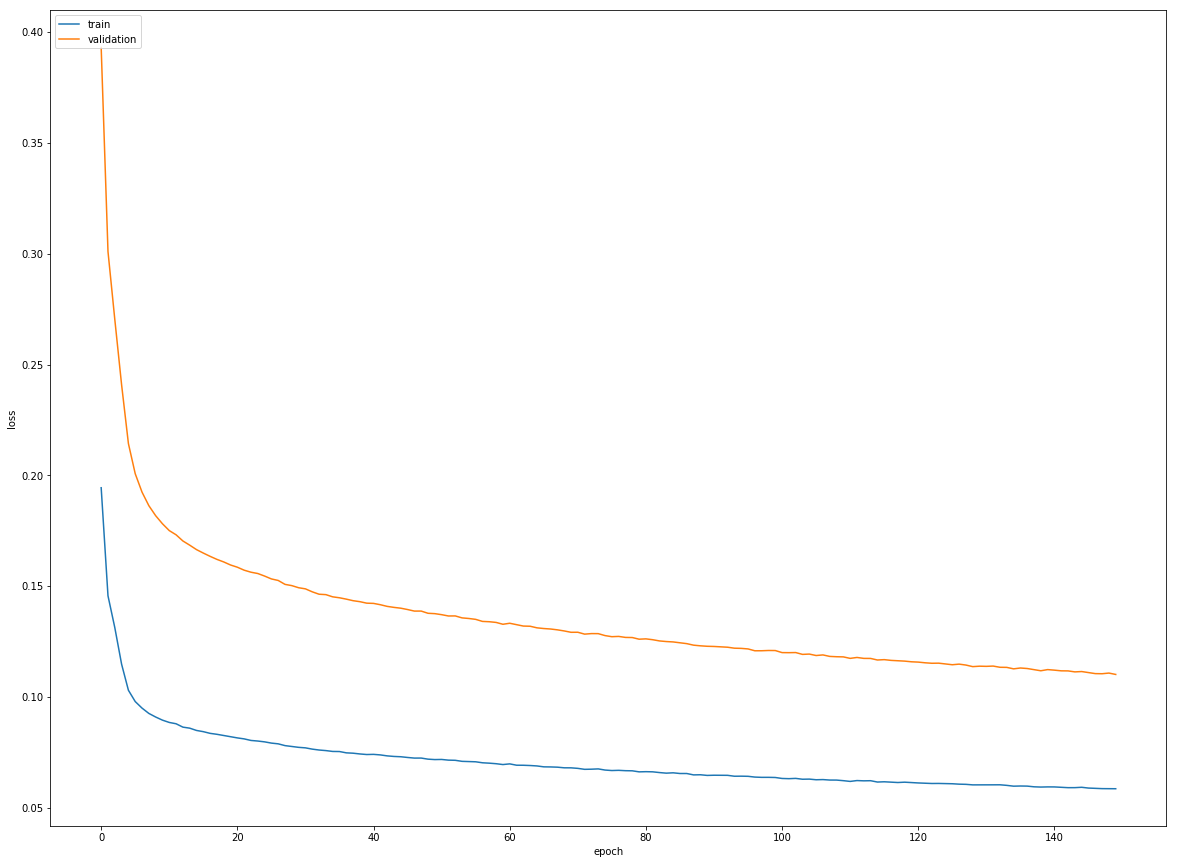

Day 1
Feature vectors: (1414, 434)
Label vectors: (1414, 403)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

----------------------------------------
Day 2
Feature vectors: (1414, 434)
Label vectors: (1414, 403)
----------------------------------------
Day 3
Feature vectors: (1414, 434)
Label vectors: (1414, 403)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------
Day 4
Feature vectors: (1414, 434)
Label vectors: (1414, 403)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

----------------------------------------
Day 5
Feature vectors: (1414, 434)
Label vectors: (1414, 403)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

----------------------------------------
Day 6
Feature vectors: (1414, 434)
Label vectors: (1414, 403)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: Undefined

----------------------------------------
Day 7
Feature vectors: (1414, 434)
Label vectors: (1414, 403)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------


In [20]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))

model = NeuralNet(X=X_train,
                  y=y_train,
                  lag=lag,
                  loss_func='mean_squared_error',
                  activation=activation,
                  optimizer='adam',
                  layers=layers,
                  dropout=dropout,
                  y_labels=y_label,
                  initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch_size,
                verbose=2,
                shuffle=False,
                plot=True)

n = 7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):

    print('Day ' + str(i + 1))

    # Segregate data for specific day
    X_validate_temp = X_validate[
                      (int(X_validate.shape[0] / n) * i):(
                      int(X_validate.shape[0] / n) * (i + 1)), :]
    y_validate_temp = y_validate[
                      (int(y_validate.shape[0] / n) * i):(
                      int(y_validate.shape[0] / n) * (i + 1)), :]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for i in range(0, X_validate_temp.shape[0]):
        X = X_validate_temp[i, :]
        X = X.reshape(1, -1)
        # X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[i, :])
        yhat = model.predict(X, batch_size=batch_size)

        y = y.reshape(1, -1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2,
                        batch_size=1,
                        verbose=0,
                        shuffle=False,
                        plot=False)  # Online Learning, Training on validation predictions.

        y = y.flatten()
        yhat = yhat.flatten()
        for i in range(yhat.shape[0]):
            y[i] = BinClass.discretize_value(y[i], .5)
            yhat[i] = BinClass.discretize_value(yhat[i], .5)
        y_list.append(y)
        yhat_list.append(yhat)

    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)

    acc_score_list, f1_score_list = [], []
    for i in range(y_list.shape[1]):
        acc = accuracy_score(y_list[:, i], yhat_list[:, i])
        f1 = f1_score(y_list[:, i], yhat_list[:, i], average='binary')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list) / len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list) / len(f1_score_list))
    print('-' * 40)

### Scoring per day

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

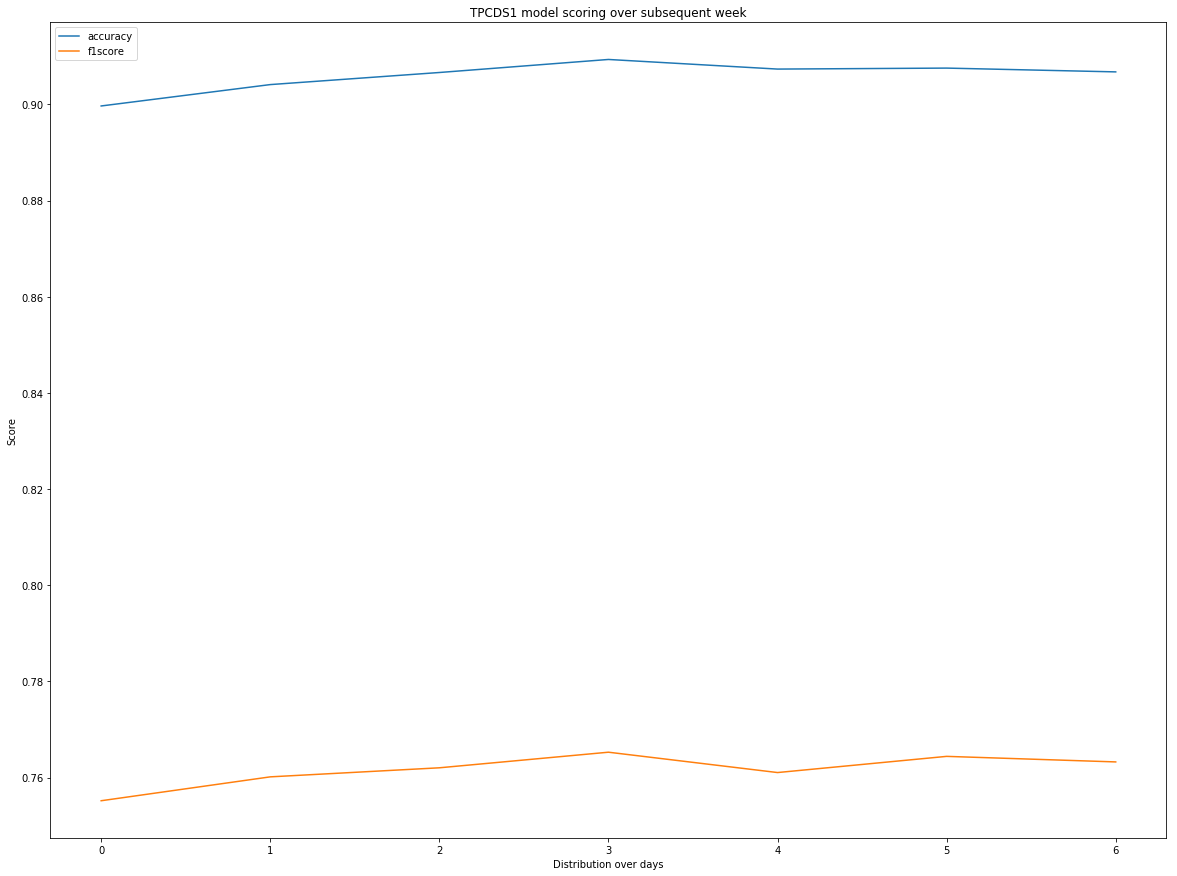

In [21]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()